# Suppress Printing

In [1]:
import sys, os
old = sys.stdout
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = old

# Load Back Projected ICA Data

In [2]:
import scipy.io as sio

In [3]:
enablePrint()
filepath = '/Users/apple/Desktop/eeglab14_1_2b/ICA_Data/EEGData1.mat'
mat_contents = sio.loadmat(filepath)
ica = mat_contents['data']
temp_trial = ica[:,:,1]
trial = ica.shape[2]
print("{}: {}".format("Total number of trials is", trial))
channel = temp_trial.shape[0]
print("{}: {}".format("Total number of channels in each trial is", channel))
timepoint = temp_trial.shape[1]
print("{}: {}".format("Total number of time points in per channel per trial is", timepoint))

Total number of trials is: 40
Total number of channels in each trial is: 32
Total number of time points in per channel per trial is: 8064


# Testing between 1 trial 2 channels with GC

In [4]:
import statsmodels.tsa.stattools as stm
import numpy as np

In [5]:
#we just gonna pick temp_trial
print(temp_trial.shape)
temp_trial = temp_trial[:,1::10]
print(temp_trial.shape)

(32, 8064)
(32, 807)


In [76]:
a = np.asarray(temp_trial[0,:])
b = np.asarray(temp_trial[1,:])
x = np.vstack((a, b)).T
print(x.shape)

(8064, 2)


In [77]:
from statsmodels.tsa.ar_model import AR
model = AR(a)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
maxlag = model_fit.k_ar
if maxlag > 5:
    maxlag =5

Lag: 36


In [78]:
addconst = True
verbose = True

In [79]:
result = stm.grangercausalitytests(x, maxlag, addconst, verbose)
optimal_lag = -1
F_test = -1.0
for key in result.keys():
    _F_test_ = result[key][0]['params_ftest'][0]
    if _F_test_ > F_test:
        F_test = _F_test_
        optimal_lag = key


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=137.4970, p=0.0000  , df_denom=8060, df_num=1
ssr based chi2 test:   chi2=137.5481, p=0.0000  , df=1
likelihood ratio test: chi2=136.3881, p=0.0000  , df=1
parameter F test:         F=137.4970, p=0.0000  , df_denom=8060, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=311.0022, p=0.0000  , df_denom=8057, df_num=2
ssr based chi2 test:   chi2=622.3905, p=0.0000  , df=2
likelihood ratio test: chi2=599.5351, p=0.0000  , df=2
parameter F test:         F=311.0022, p=0.0000  , df_denom=8057, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=283.9087, p=0.0000  , df_denom=8054, df_num=3
ssr based chi2 test:   chi2=852.4664, p=0.0000  , df=3
likelihood ratio test: chi2=810.3369, p=0.0000  , df=3
parameter F test:         F=283.9087, p=0.0000  , df_denom=8054, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=215.8010, p=0.

In [80]:
print("{} {}".format("We are going to look into the GC with Optimal Lag of", optimal_lag))

We are going to look into the GC with Optimal Lag of 2


We consider the p-value of the test as a measure for Granger causality: rejection of ℋ0 (p < 0.03) signifies Granger causality, acceptance means non-causality.

The causality relations drawn from systems with very small values of |det(ΛˆI)| are not meaningful

In [11]:
if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
    print(result[optimal_lag][0]['params_ftest'][0])

# Compute one Multivariant Granger Causality Matrix MGCM

In [81]:
from matplotlib import pyplot
import math
import time

In [86]:
time_start = time.clock()
MGCM = np.zeros((channel,channel))
for i in range(channel):
    for j in range(channel):
        if i == j:
            blockPrint()
            print("{}:{}".format(i,j))
            MGCM[i,j] = 0
        blockPrint()
        a = np.asarray(temp_trial[i,:])
        b = np.asarray(temp_trial[j,:])
        x = np.vstack((a, b)).T
        model = AR(a)
        model_fit = model.fit()
        maxlag = model_fit.k_ar
        if maxlag > 5:
            maxlag = 5
        result = stm.grangercausalitytests(x, maxlag, addconst = True, verbose = True)
        optimal_lag = -1
        F_test = -1.0
        for key in result.keys():
            _F_test_ = result[key][0]['params_ftest'][0]
            if _F_test_ > F_test:
                F_test = _F_test_
                optimal_lag = key
        if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
            MGCM[i,j] = math.log(result[optimal_lag][0]['params_ftest'][0])
        else:
            MGCM[i,j] = 0
blockPrint()
diag = np.max(MGCM)
for i in range(channel):
    for j in range(channel):
        if i == j:
            MGCM[i,j] = 1
        else:
            MGCM[i,j] = MGCM[i,j]/diag

Time Used: 189.257473


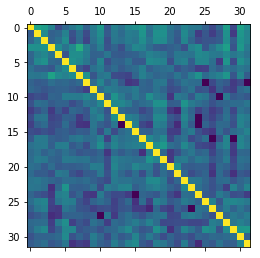

In [87]:
enablePrint()
pyplot.matshow(MGCM)
pyplot.show()
time_elapsed = (time.clock() - time_start)
print("{}: {}".format("Time Used", time_elapsed))

In [88]:
print(np.mean(MGCM))
print(np.median(MGCM))
print(np.max(MGCM))
print(np.min(MGCM))

0.35693551284594077
0.3423807029848485
1.0
0.0


In [89]:
print("{}:{}".format("Hours needed", time_elapsed*40*32/60/60))

Hours needed:67.29154595555556


In [32]:
#GoogleColab takes 34 seconds

# Split data computing MGCM for LSTM

In [98]:
temp_trial = ica[:,:,1]
trial = ica.shape[2]
print("{}: {}".format("Total number of trials is", trial))
channel = temp_trial.shape[0]
print("{}: {}".format("Total number of channels in each trial is", channel))
timepoint = temp_trial.shape[1]
print("{}: {}".format("Total number of time points in per channel per trial is", timepoint))

In [99]:
from matplotlib import pyplot
import math
import time

In [100]:
hz = 128
#a 3 second pre-trial baseline removed
lstm_trial = temp_trial[:,128*3:]
print(temp_trial.shape)
print(lstm_trial.shape)

In [101]:
current_trial = lstm_trial[:,0*hz:(0+1)*hz]
print(current_trial.shape)

In [102]:
from statsmodels.tsa.ar_model import AR
a = np.asarray(current_trial[0,:])
b = np.asarray(current_trial[17,:])
x = np.vstack((a, b)).T
print(x.shape)

model = AR(a)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
maxlag = model_fit.k_ar
if maxlag > 8:
    maxlag =8

In [104]:
blockPrint()
result = stm.grangercausalitytests(x, maxlag, addconst, verbose)
optimal_lag = -1
F_test = -1.0
for key in result.keys():
    _F_test_ = result[key][0]['params_ftest'][0]
    if _F_test_ > F_test:
        F_test = _F_test_
        optimal_lag = key
enablePrint()
print("{} {}".format("We are going to look into the GC with Optimal Lag of", optimal_lag))

We are going to look into the GC with Optimal Lag of 7


Here split the dataset second by second and compute the MGCM for each 128 datapoints. Since 7680/128 = 60 seconds, the sanity check is good

In [ ]:
time_start = time.clock()
for k in range(60):
    print(k)
    blockPrint()
    current_trial = lstm_trial[k*hz:(k+1)*hz]
    for i in range(channel):
        for j in range(channel):
            if i == j:
                print("{} -> {}:{}".format(k,i,j))
                MGCM[i,j] = 0
            blockPrint()
            a = np.asarray(current_trial[i,:])
            b = np.asarray(current_trial[j,:])
            x = np.vstack((a, b)).T
            model = AR(a)
            model_fit = model.fit()
            maxlag = model_fit.k_ar
            if maxlag > 8:
                maxlag = 8
            result = stm.grangercausalitytests(x, maxlag, addconst = True, verbose = True)
            optimal_lag = -1
            F_test = -1.0
            for key in result.keys():
                _F_test_ = result[key][0]['params_ftest'][0]
                if _F_test_ > F_test:
                    F_test = _F_test_
                    optimal_lag = key
            if (result[optimal_lag][0]['params_ftest'][1] < 0.03):
                MGCM[i,j] = math.log(result[optimal_lag][0]['params_ftest'][0])
            else:
                MGCM[i,j] = 0
    enablePrint()
    diag = np.max(MGCM)
    print(diag)
    for i in range(channel):
        for j in range(channel):
            if i == j:
                MGCM[i,j] = 1
            else:
                MGCM[i,j] = MGCM[i,j]/diag
    enablePrint()
    pyplot.matshow(MGCM)
    pyplot.show()
time_elapsed = (time.clock() - time_start)
print("{}: {}".format("Time Used", time_elapsed))

0
